In [1]:
import sys

sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')

from weights import Beta
from base import BaseModel
from helper_functions import create_matrix
from stats import loglikelihood_normal
from volatility import Panel_GARCH, Panel_GARCH_CSA, Panel_MIDAS, Panel_GARCH_MIDAS, MGARCH
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import time
from pandas.tseries.offsets import BDay

%matplotlib inline

plt.style.use('bmh')

## Forecasting

The conditional variance of a GARCH(1, 1) process can be forecasted for the t + $\tau$ with $\tau > 0$. First, for the one step ahead forecast:

$\sigma_{t + 1 | t}^2 = E[\epsilon_{t + 1}^2 | \mathcal{F}_t] = \alpha_0 + \alpha \epsilon_t + \beta \sigma_t^2$

For $\tau = 2$ we get

$\sigma_{t + 2 | t}^2 = E[\epsilon_{t + 2}^2 | \mathcal{F}_t] = \alpha_0 + (\alpha + \beta) E[\epsilon_{t + 1}^2 | \mathcal{F}_t] = \\
= \alpha_0 + (\alpha + \beta) \sigma_{t + 1 | t}^2$

Iteration leads us to:

$\sigma_{t + \tau | t}^2 = \alpha_0 \frac{1 - (\alpha + \beta)^{\tau - 1}}{1 - \alpha - \beta} + (\alpha + \beta)^{\tau - 1} \sigma_{t + 1 | t}^2 $

As we increase the forecast horizon above all limits, we have

$\lim_{\tau\to\infty} \sigma_{t + \tau | t}^2 = \frac{\alpha0}{1 - \alpha - \beta} = V[\epsilon_t]$

As we use our simplification, that said we can estimate unconditional variance by the mean of squared returns, we can rewrite these equations for the following:

$\sigma_{t + \tau | t}^2 = \hat{\mu} (1 - (\alpha + \beta)^{\tau - 1}) + (\alpha + \beta)^{\tau - 1} \sigma_{t + 1 | t}^2 $


In [6]:
data = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/data_matrix.csv')

In [7]:
data.set_index(pd.to_datetime(data.iloc[:, 0]), inplace = True)

In [8]:
data = data.iloc[:, 1:]

In [9]:
data

,AAII,VIX,NFCI,CFNAI,IP_delta,HOUST_delta,DTB3,soyc,BAA10Y,Inflation,UNRATE,PPI_delta,M2_delta,csh_delta
Unnamed: 0,,,,,,,,,,,,,,
1997-01-01,0.042500,19.234545,-0.736012,0.26,0.1130,-15.0,4.910952,1.391429,1.588636,0.300,5.3,0.6,0.004181,0.040
1997-02-01,0.192000,19.536087,-0.689170,0.79,0.9657,131.0,5.033810,1.545238,1.518261,0.300,5.2,-1.2,0.003046,0.066
1997-03-01,0.305000,20.091500,-0.751732,0.28,0.5410,-29.0,5.005789,1.413684,1.522500,0.100,5.2,-1.2,0.003866,0.315
1997-04-01,0.087500,20.185714,-0.751430,0.06,0.0191,35.0,5.144000,1.550500,1.484762,0.100,5.1,-0.3,0.004135,0.409
1997-05-01,-0.035000,19.662273,-0.693043,0.19,0.4762,-50.0,5.162273,1.723182,1.451364,0.000,4.9,0.4,0.003142,0.544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-01,-0.140688,31.119545,-0.319640,2.69,4.1067,222.0,0.159545,0.569091,2.913182,1.322,10.2,1.8,0.007764,1.760
2020-08-01,-0.205616,26.876957,-0.372862,1.11,0.9799,-114.0,0.126818,0.496818,2.697391,0.907,8.4,1.3,0.003449,2.478
2020-09-01,-0.139910,22.889524,-0.516713,0.45,-0.0857,64.0,0.104286,0.545714,2.624286,0.638,7.8,1.2,0.012159,2.751


In [10]:
ret_matrix = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/ret_matrix.csv')
ret_matrix.set_index(pd.to_datetime(ret_matrix.Date), inplace = True)
ret_matrix = ret_matrix.iloc[:, 1:] * 100

In [11]:
ret_matrix.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5272 entries, 1999-11-18 to 2020-10-30
Columns: 493 entries, A to ZTS
dtypes: float64(493)
memory usage: 19.9 MB


In [12]:
ret_mat = ret_matrix.iloc[1:, :]
nan_cols = np.where(ret_mat.isna().sum().values == 1)[0]
nan_index = np.where(ret_mat.iloc[:, nan_cols].isna() == True)[0]
print(set(nan_index))

{455}


In [13]:
if len(set(nan_index)) == 1.0:
    ret_mat = ret_mat.drop([ret_mat.index[nan_index[0]]])

In [14]:
print(np.where(ret_mat.isna().sum().values == 1)[0])

[]


In [26]:
X = data[(data.index >= datetime(1999,12,1)) & (data.index <= datetime(2007,12,1))].iloc[:, :]
X

,AAII,VIX,NFCI,CFNAI,IP_delta,HOUST_delta,DTB3,soyc,BAA10Y,Inflation,UNRATE,PPI_delta,M2_delta,csh_delta
Unnamed: 0,,,,,,,,,,,,,,
1999-12-01,0.262500,21.747273,-0.227258,0.57,0.7222,60.0,5.070500,0.963500,2.112727,0.400,4.0,-0.5,0.005946,0.394
2000-01-01,0.428000,22.113913,-0.242620,0.21,0.0165,-72.0,5.196364,1.079091,1.910435,0.500,4.0,0.5,0.006061,0.451
2000-02-01,0.437550,23.033333,-0.260630,-0.25,0.2799,101.0,5.318500,1.342500,1.674286,0.700,4.1,1.5,0.002824,0.571
2000-03-01,0.135000,23.710000,-0.272038,0.42,0.3423,-133.0,5.548000,0.971500,1.770000,1.000,4.0,1.0,0.006538,0.895
2000-04-01,0.225860,22.718261,-0.188520,0.47,0.6828,22.0,5.694783,0.561739,2.110870,-0.100,3.8,-0.1,0.011817,1.074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-08-01,0.092575,17.166364,-0.471827,-0.08,0.2329,-24.0,4.821429,0.182857,1.645909,0.064,4.6,-2.7,0.010400,-0.758
2007-09-01,0.003020,25.026087,0.000156,-0.01,0.4055,-147.0,4.201739,0.473043,1.977391,0.880,4.7,1.1,0.002475,-1.114
2007-10-01,0.058625,22.258000,0.179510,-0.32,-0.4440,81.0,3.892105,0.629474,2.069500,0.643,4.7,1.2,0.001836,-1.593


In [27]:
y = ret_mat[(ret_mat.index >= X.index[0]) & (ret_mat.index < X.index[-1])]
y

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-01,1.762178,NaN,NaN,5.164480,NaN,0.503771,-0.405680,-1.491311,NaN,-3.142563,...,-0.069810,3.940294,-2.110971,-2.515317,NaN,-1.977239,NaN,-1.459874,1.154995,NaN
1999-12-02,2.728095,NaN,NaN,6.684766,NaN,-2.544623,0.809721,0.374895,NaN,3.051530,...,5.638132,-0.512683,-2.156383,-0.947849,NaN,-1.081107,NaN,-3.419138,0.857531,NaN
1999-12-03,0.846262,NaN,NaN,4.274904,NaN,-3.141606,-1.421344,-0.374895,NaN,-2.863924,...,-6.974775,0.550482,4.005884,-1.197612,NaN,-0.623022,NaN,1.510278,2.529405,NaN
1999-12-06,2.770258,NaN,NaN,0.865724,NaN,1.583089,0.000000,-2.879155,NaN,-5.490060,...,3.068556,1.615089,-3.462417,0.480733,NaN,0.156091,NaN,-1.401646,-2.529405,NaN
1999-12-07,-1.098914,NaN,NaN,1.550422,NaN,-1.052634,0.611623,-1.558476,NaN,-4.040944,...,-2.433231,0.000000,0.540565,-2.181862,NaN,0.466931,NaN,-3.199382,-3.475206,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-11-26,-1.007479,-4.010538,-2.573713,0.581229,NaN,-0.594154,-3.448618,-2.259952,-3.708414,-2.439436,...,-2.473844,-3.000757,-1.756896,-2.136196,NaN,-2.012080,-1.278465,-0.190450,-5.636672,NaN
2007-11-27,0.790522,-0.204837,0.149694,1.307064,NaN,-1.059911,-0.083579,3.014006,-0.295612,0.414782,...,2.196840,0.813648,3.338566,0.553688,NaN,-0.108501,1.340416,1.781423,1.994231,NaN
2007-11-28,2.995678,7.216566,2.190079,3.047881,NaN,2.876898,3.774033,0.908042,3.118447,2.310570,...,2.194874,1.767099,2.031360,3.555666,NaN,0.891313,1.230980,1.566058,5.017540,NaN


In [28]:
pgm = Panel_GARCH_MIDAS()

In [29]:
rest_midas = ['pos'] + ['pos', 'pos'] * X.shape[1]
rest_garch = ['01', '01']
pgm.fit(rest_midas, rest_garch, X, y)

Estimated parameters for the MIDAS equation:



C:/Users/peter/Desktop/volatility-forecasting/midas\base.py:47: RuntimeWarning: overflow encountered in exp
  g[i] = np.exp(param_trans[i])


Loglikelihood:  999.8380317849505 

      Parameters  Standard Error   95% CI Lower  95% CI Higher
0   1.123606e-03    8.830728e-01  -1.729667e+00   1.731915e+00
1   1.639061e-02    2.037207e-01  -3.828945e-01   4.156757e-01
2   3.648792e-02    2.342676e-01  -4.226681e-01   4.956439e-01
3   2.319068e-04    2.040014e-01  -3.996035e-01   4.000673e-01
4   2.814093e-01    1.630361e-01  -3.813563e-02   6.009543e-01
5   2.046677e+00    3.805933e-01   1.300728e+00   2.792626e+00
6   1.337635e+00    4.340284e-01   4.869554e-01   2.188315e+00
7   3.613687e-05    5.309621e-01  -1.040631e+00   1.040703e+00
8   2.156444e+00    8.855002e-01   4.208957e-01   3.891993e+00
9   5.995862e-01    2.391652e-01   1.308311e-01   1.068341e+00
10  1.684918e+00    6.397674e-01   4.309973e-01   2.938839e+00
11  2.098368e-07    4.373702e-01  -8.572297e-01   8.572301e-01
12  8.796823e-01    2.476022e-01   3.943909e-01   1.364974e+00
13  2.628922e-01    6.552927e-02   1.344572e-01   3.913272e-01
14  2.080492e+01   

In [30]:
y_hat = pgm.calculate_y_hat(y, pgm.midas.tau_t)

<ipython-input-31-33803abf8121>:1: RuntimeWarning: Mean of empty slice
  mu_un = np.nanmean(y ** 2, axis = 0)
<ipython-input-31-33803abf8121>:2: RuntimeWarning: Mean of empty slice
  mu_hat = np.nanmean(y_hat**2, axis = 0)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


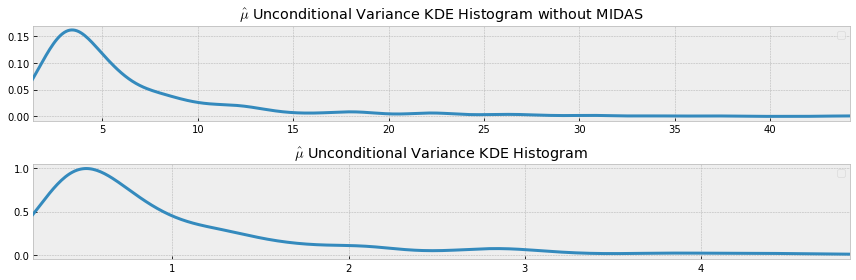

In [31]:
mu_un = np.nanmean(y ** 2, axis = 0)
mu_hat = np.nanmean(y_hat**2, axis = 0)

mu_un = mu_un[np.where(pd.Series(mu_un).isna() == False)]
mu_hat = mu_hat[np.where(pd.Series(mu_hat).isna() == False)]

mun = sm.nonparametric.KDEUnivariate(mu_un)
mun.fit()
muh = sm.nonparametric.KDEUnivariate(mu_hat)
muh.fit()

fig , ax = plt.subplots(2, 1, figsize=(12, 4), tight_layout=True)

ax[0].plot(mun.support, mun.density, lw = 3, zorder = 10)
ax[0].set_title(r'$\hat{\mu}$'+" Unconditional Variance KDE Histogram without MIDAS")
ax[0].grid(True, zorder = -5)
ax[0].set_xlim((np.min(mu_un), np.max(mu_un)))
ax[0].legend(loc = 'best')

ax[1].plot(muh.support, muh.density, lw = 3, zorder = 10)
ax[1].set_title(r'$\hat{\mu}$'+" Unconditional Variance KDE Histogram")
ax[1].grid(True, zorder = -5)
ax[1].set_xlim((np.min(mu_hat), np.max(mu_hat)))
ax[1].legend(loc = 'best')

plt.show()

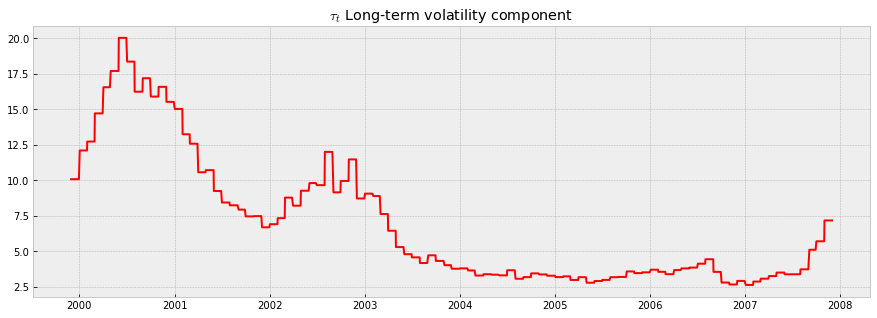

In [32]:
plt.figure(figsize = (15, 5))
plt.plot(y.index, pgm.midas.tau_t, 'r')
plt.title(r'$\tau_t$'+' Long-term volatility component')
plt.grid(True)
plt.show()

In [33]:
xom = y['XOM'] / pgm.midas.tau_t
xom_vola = pgm.garch.model_filter(pgm.garch.optimized_params, xom)

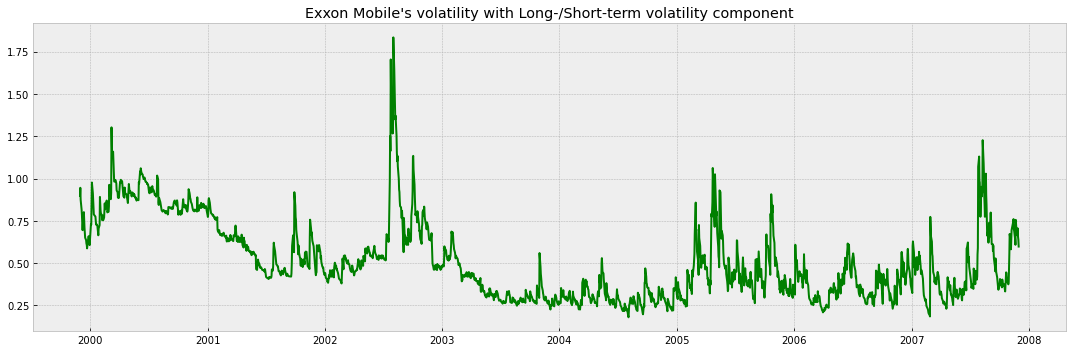

In [36]:
plt.figure(figsize = (15, 5))
plt.plot(xom.index, xom_vola * pgm.midas.tau_t, 'g')
plt.title("Exxon Mobile's volatility with Long-/Short-term volatility component")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
mu = np.mean(xom ** 2)
alpha, beta = pgm.garch.optimized_params

In [30]:
H = 66
forecast = np.zeros(H)

for i in range(1, H + 1):
    forecast[i - 1] = (mu * (1 - (alpha + beta) ** (i - 1)) + xom_vola[-1] * (alpha + beta) ** (i - 1)) * pgm.midas.tau_t[-1]

In [31]:
index = []
for i in range(len(y.index) + H):
    if i < len(y.index):
        index.append(y.index[i])
    else:
        index.append(y.index[-1] + BDay(i - len(y.index) + 1))

In [32]:
vola = np.zeros(len(xom_vola) + H)
vola[:-H] = xom_vola * pgm.midas.tau_t
vola[-H:] = forecast

XOM_vola = pd.Series(data = vola, index = index)

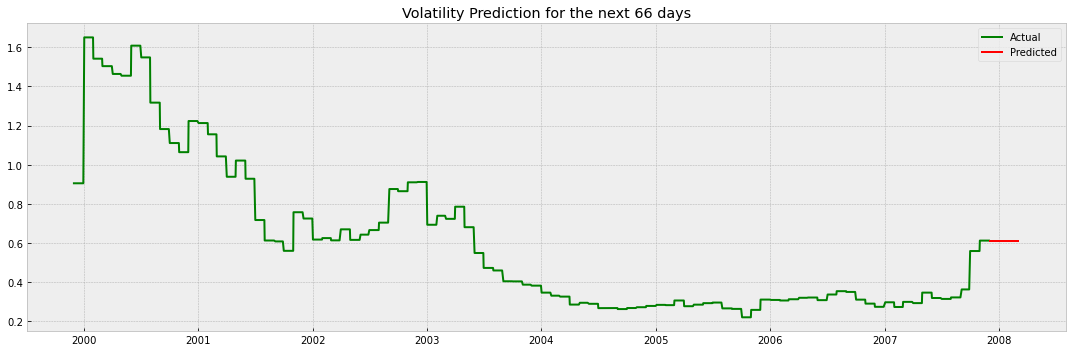

In [35]:
plt.figure(figsize = (15, 5))
plt.plot(XOM_vola[XOM_vola.index <= pd.to_datetime(y.index[-1])], 'g', label = 'Actual')
plt.plot(XOM_vola[XOM_vola.index > pd.to_datetime(y.index[-1])], 'r', label = 'Predicted')
plt.title("Volatility Prediction for the next {} days".format(H))
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [36]:
y_hat = pgm.calculate_y_hat(y, pgm.midas.tau_t)

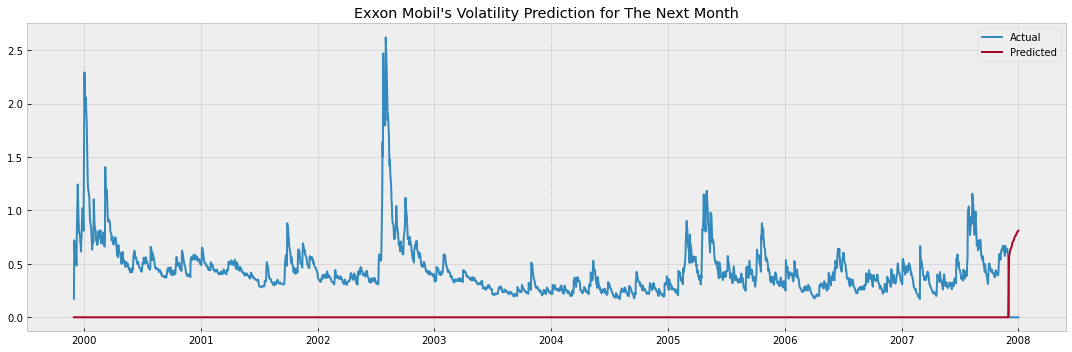

In [70]:
plt.figure(figsize = (15, 5))
plt.plot(index, vola, label = 'Actual')
plt.plot(index, sima, label = 'Predicted')
plt.title("Exxon Mobil's Volatility Prediction for The Next Month")
plt.legend(loc = 'best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
mgarch = MGARCH(lag = 12, plot = True)

In [46]:
rest = ['01', '01', 'pos'] + ['pos', 'pos'] * X.shape[1]
mgarch.fit(rest, X.iloc[:, :1], y.XOM)

Loglikelihood:  1.7664861255514452 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.061027        0.105543     -0.145834       0.267889
1    0.927465        0.060777      0.808345       1.046585
2    1.145214        4.182853     -7.053027       9.343455
3    0.005072        0.436813     -0.851066       0.861211
4    3.363829       68.038440   -129.989062     136.716721


In [47]:
XOM_volat = mgarch.predict(X.iloc[:, :1], y.XOM)

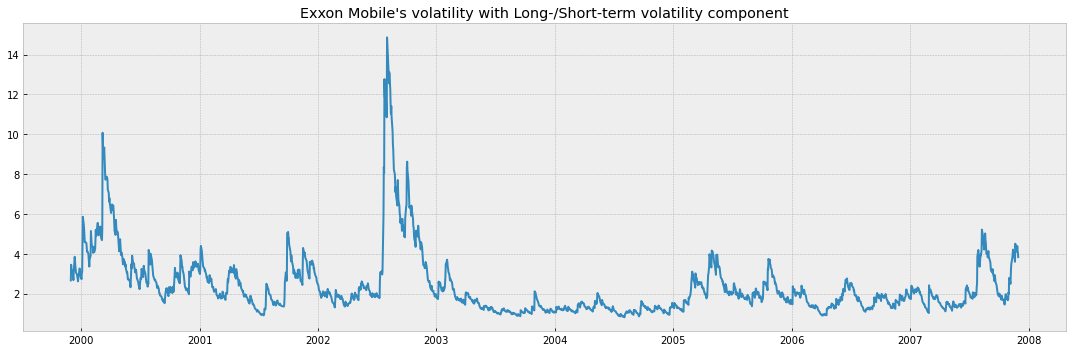

In [48]:
plt.figure(figsize = (15, 5))
plt.plot(y.XOM.index, XOM_volat)
plt.title("Exxon Mobile's volatility with Long-/Short-term volatility component")
plt.grid(True)
plt.tight_layout()
plt.show()

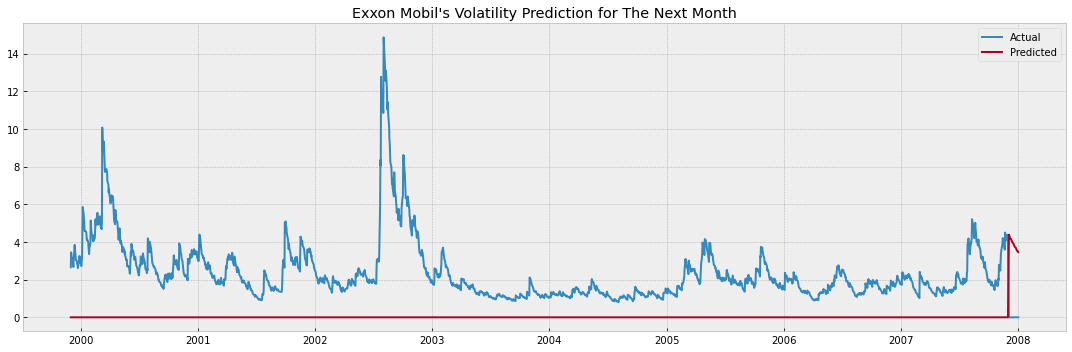

In [43]:
plt.figure(figsize = (15, 5))
plt.plot(index, volat, label = 'Actual')
plt.plot(index, forc, label = 'Predicted')
plt.title("Exxon Mobil's Volatility Prediction for The Next Month")
plt.legend(loc = 'best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [88]:
from volatility import Panel_GARCH

In [89]:
panel_garch = Panel_GARCH()

In [90]:
panel_garch.fit(['01', '01'], y)

C:/Users/peter/Desktop/volatility-forecasting/midas\stats.py:35: RuntimeWarning: invalid value encountered in log
  lls = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + resid ** 2 / sigma2)
C:/Users/peter/Desktop/volatility-forecasting/midas\stats.py:35: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + resid ** 2 / sigma2)
C:/Users/peter/Desktop/volatility-forecasting/midas\stats.py:35: RuntimeWarning: divide by zero encountered in true_divide
  lls = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + resid ** 2 / sigma2)
C:/Users/peter/Desktop/volatility-forecasting/midas\stats.py:35: RuntimeWarning: invalid value encountered in add
  lls = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + resid ** 2 / sigma2)
C:/Users/peter/Desktop/volatility-forecasting/midas\stats.py:35: RuntimeWarning: invalid value encountered in true_divide
  lls = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + resid ** 2 / sigma2)


Loglikelihood:  979.6423706192636 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.00007        0.005575     -0.010857       0.010996
1     1.00000        0.004384      0.991407       1.008593


In [91]:
forc = forecast(pg.optimized_params, y.XOM, pg.model_filter(pg.optimized_params, y.XOM), H = 22)

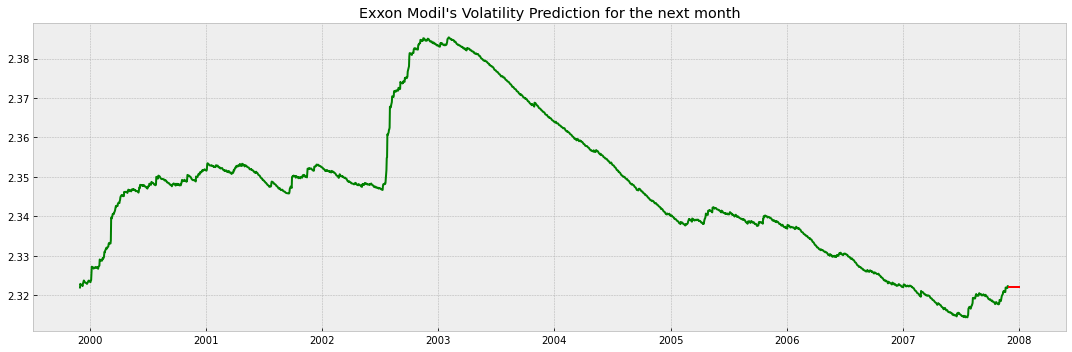

In [108]:
plt.figure(figsize = (15, 5))
plt.plot(forc[forc.index <= pd.to_datetime(y.XOM.index[-1])], 'g')
plt.plot(forc[forc.index > pd.to_datetime(y.XOM.index[-1])], 'r')
plt.title("Exxon Modil's Volatility Prediction for the next month")
plt.tight_layout()
plt.show()